In [1]:
import pycurl
from io import BytesIO
import json
import pandas as pd
import numpy as np

Retrieving the given JSON BLOB object using pyCurl

In [2]:
b_obj = BytesIO() 
crl = pycurl.Curl() 

crl.setopt(crl.URL, 'https://jsonblob.com/api/jsonBlob/f0b70eef-566b-11eb-9d92-415b3ac53928')
crl.setopt(crl.WRITEDATA, b_obj)
crl.perform() 
crl.close()

get_body = b_obj.getvalue()

data = json.loads(get_body.decode('utf8'))

Cleaning and pre-processing the data by performing stopword-removal, splitting alphanumeric words and lemmatizing words. 
Then, pre-processed data is loaded into a pandas dataframe row-by-row.

In [3]:
import re
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

snow_stemmer = SnowballStemmer(language='english')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer() 

df = pd.DataFrame(columns=['description', 'label'])

for i in range(len(data)):
    curr_desc = (data[i]['req']['body']['note']['desc']).lower()
    curr_desc = curr_desc.replace('\n','')
    curr_desc = curr_desc.replace('.',' ')
    
    temp = ''
    for word in re.findall(r"[^\W\d_]+|\d+",curr_desc):
        temp+=word+' '
    temp = temp.strip()
    
    temp2 = ''
    for word in temp.split(' '):
        if word not in stop_words and len(word)>0:
            temp2+=word+' '
    temp2 = temp2.strip()
    
    temp3 = ''
    for word in temp2.split(' '):
        temp3+=lemmatizer.lemmatize(word)+' '
        #temp3+=snow_stemmer.stem(word)+' '
    temp3 = temp3.strip()
    
    curr_label = int(data[i]['isSafe']) #0 for False 1 for True
    df = df.append({'description':temp3,'label':curr_label},ignore_index=True)

Droppping duplicate rows in the dataframe

In [4]:
print('Shape of dataframe prior to removal of duplicate rows: ',df.shape)
df.drop_duplicates(keep='first',inplace=True)
print('Shape of dataframe post removal of duplicate rows: ',df.shape)

Shape of dataframe prior to removal of duplicate rows:  (1000, 2)
Shape of dataframe post removal of duplicate rows:  (750, 2)


Converting data and labels to numpy arrays

In [5]:
X = np.array(df['description'])
Y = np.array(df['label'],dtype=np.int)

Calculating the maximum length of a sentence in the data (to be used for optimization and model creation)

In [6]:
maxlen = 0
for i in X:
    currlen = len(i.split(' '))
    if currlen>=maxlen:
        maxlen = currlen
print(maxlen)

31


Calculating the amount of class imbalance in the dataset

In [7]:
def get_class_ratio(array):
    zeros = 0
    ones = 0
    for i in array:
        if i==0:
            zeros+=1
        elif i==1:
            ones+=1
        else:
            print(i,' target class value is neither one nor zero')
    return zeros,ones,(zeros/ones)

zero, ones, ration = get_class_ratio(Y)
print('Number of Instances of Class 0 =',zero)
print('Number of Instances of Class 1 =',ones)
print('Ratio of class 0 to class 1 =',ration)

def batch_generator(x,y,batch_size):
    half = batch_size//2
    x_batch = np.empty((batch_size,maxlen),dtype=np.float32)
    y_batch = np.empty((batch_size),dtype=np.int)
    safe_indexes = np.where(y[:]==1)[0]
    unsafe_indexes = np.where(y[:]==0)[0]
    
    while True:
        np.random.shuffle(safe_indexes)
        np.random.shuffle(unsafe_indexes)
        x_batch[:half] = x[safe_indexes[:half]]
        x_batch[half:] = x[unsafe_indexes[half:batch_size]]
        y_batch[:half] = y[safe_indexes[:half]]
        y_batch[half:] = y[unsafe_indexes[half:batch_size]]
        yield x_batch, y_batch

Number of Instances of Class 0 = 178
Number of Instances of Class 1 = 572
Ratio of class 0 to class 1 = 0.3111888111888112


Tokenizing and padding the data

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences,maxlen=maxlen,padding='post')
vocab_size = len(tokenizer.word_index)+1

Splitting the dataset into training, validation, and testing sets

In [50]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val = train_test_split(padded_sequences,Y,test_size=0.15,random_state=69420,shuffle=True)
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.15,random_state=69420,shuffle=True)

In [51]:
print(np.where(y_train[:]==0)[0].shape)
print(np.where(y_val==0)[0].shape)
print(np.where(y_test==0)[0].shape)

(127,)
(28,)
(23,)


Un-pickling the pickled embedding vector

In [52]:
import pickle

'''picklefile = open('C:\\Users\\Azaghast\\Downloads\\glove.840B.300d\\embedding_vector_pickledump.txt','wb')
pickle.dump(embedding_vector,picklefile)
picklefile.close()'''

vectors = open('C:\\Users\\Azaghast\\Downloads\\glove.840B.300d\\embedding_vector_pickledump.txt','rb')
embedding_vector = pickle.load(vectors)
vectors.close()

Creating the embedding matrix to be used in the bidirectional LSTM model

In [53]:
embedding_matrix = np.zeros((vocab_size,300))
for word,i in tokenizer.word_index.items():
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

In [54]:
embedding_matrix.shape

(902, 300)

In [55]:
'''embedding_vector = {}
f = open('C:\\Users\\Azaghast\\Downloads\\glove.840B.300d\\glove.840B.300d.txt',encoding='utf-8')
for line in f:
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype=np.float32)
    embedding_vector[word] = coef'''

"embedding_vector = {}\nf = open('C:\\Users\\Azaghast\\Downloads\\glove.840B.300d\\glove.840B.300d.txt',encoding='utf-8')\nfor line in f:\n    value = line.split(' ')\n    word = value[0]\n    coef = np.array(value[1:],dtype=np.float32)\n    embedding_vector[word] = coef"

Creating a bidirectional LSTM model to classify the data

In [56]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional
import tensorflow

class custom_callback(tensorflow.keras.callbacks.Callback):#callback to end training at an optimal time so as to get very good model weights
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get('val_accuracy'))>0.57 and (logs.get('accuracy'))>0.99:
            print("Training accuracy > 99 % and validation accuracy > 57 % so training has been stopped")
            self.model.stop_training=True

callback = custom_callback()
            
model = Sequential()
model.add(Embedding(vocab_size,300,weights=[embedding_matrix],input_length=maxlen,trainable=False))
model.add(Bidirectional(LSTM(128,dropout=0.5)))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 31, 300)           270600    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_12 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 718,153
Trainable params: 447,553
Non-trainable params: 270,600
_________________________________________________________________


Fitting the model on the training data and validating on validation data on-the-fly for 100 epochs or until callback condition is satisfied

In [57]:
history = model.fit(batch_generator(x_train,y_train,64),
                    epochs=100,
                    steps_per_epoch=64,
                    validation_data=batch_generator(x_val,y_val,16),
                    validation_steps=16,
                    callbacks=[callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 64 steps, validate for 16 steps
Epoch 1/100
64/64 [==============================] - 4s 57ms/step - loss: 0.5557 - accuracy: 0.7070 - val_loss: 1.2653 - val_accuracy: 0.4102
Epoch 2/100
64/64 [==============================] - 1s 10ms/step - loss: 0.2975 - accuracy: 0.8743 - val_loss: 1.7960 - val_accuracy: 0.4453
Epoch 3/100
64/64 [==============================] - 1s 11ms/step - loss: 0.1512 - accuracy: 0.9419 - val_loss: 1.6824 - val_accuracy: 0.5039
Epoch 4/100
64/64 [==============================] - 1s 10ms/step - loss: 0.0785 - accuracy: 0.9724 - val_loss: 2.3966 - val_accuracy: 0.4531
Epoch 5/100
64/64 [==============================] - 1s 10ms/step - loss: 0.0522 - accuracy: 0.9841 - val_loss: 2.6089 - val_accuracy: 0.4844
Epoch 6/100
64/64 [==============================] - 1s 10ms/step - loss: 0.0322 - accuracy: 0.9878 - val_loss: 2.9991 - val_accuracy: 0.4727
Epoch 7/100
64/64 [==============================] - 1s 

Plotting Loss and Accuracy of both Training and Validation sets

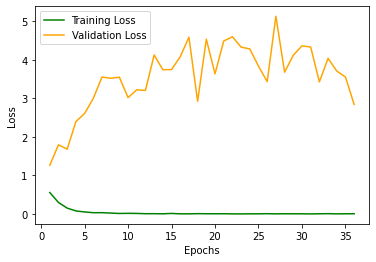

In [58]:
import matplotlib.pyplot as plt

EPOCHS = 36

history_obj = history.history
epochs = [i for i in range(1,EPOCHS+1)]

plt.plot(epochs,history_obj['loss'],color='green',label='Training Loss')
plt.plot(epochs,history_obj['val_loss'],color='orange',label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

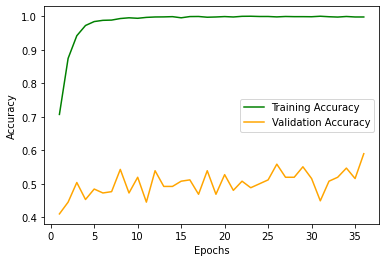

In [59]:
plt.plot(epochs,history_obj['accuracy'],color='green',label='Training Accuracy')
plt.plot(epochs,history_obj['val_accuracy'],color='orange',label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Generating the classification report (containing precision, recall, f1-score, and accuracy) for the model's performance on the test set

In [60]:
from sklearn.metrics import classification_report

bilstm_pred = model.predict(x_test)
bilstm_binary = [1 if i>0.5 else 0 for i in bilstm_pred]
bilstm_report = classification_report(y_test,bilstm_binary)
print(bilstm_report)

              precision    recall  f1-score   support

           0       0.52      0.52      0.52        23
           1       0.85      0.85      0.85        73

    accuracy                           0.77        96
   macro avg       0.69      0.69      0.69        96
weighted avg       0.77      0.77      0.77        96



Bidirectional-LSTM Model Performance on Test Set:

Class 0 represents for unsafe statements, class 1 represents safe queries

Class 0: Precision = 52 %, Recall = 52 %, F1-Score = 52 %
Class 1: Precision = 85 %, Recall = 85 %, F1-Score = 85 %